## Conjunto de entrenamiento y evaluación

Una vez cargado el dataset, podemos generar subconjuntos del mismo para el entrenamiento y evaluación del modelo. 

Para ello, hacemos uso de la función [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) del módulo [`model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection).


In [1]:
from sklearn.datasets import load_digits
 
dataset = load_digits()

# Divido los datos en conjunto de entrenamiento y evaluacion
from sklearn.model_selection import train_test_split
 
data_train, data_test, target_train, target_test = train_test_split(dataset.data,
                                                                    dataset.target,
                                                                    test_size = 0.2)
 
print("Ahora, el conjunto de entrenamiento tiene {} muestras y el de evaluación tiene {} muestras.".format(data_train.shape[0], data_test.shape[0]))

Ahora, el conjunto de entrenamiento tiene 1437 muestras y el de evaluación tiene 360 muestras.


In [2]:
from sklearn.tree._tree import TREE_LEAF
from copy import deepcopy

# Funcion para podar un árbol.

# NOTA: Para reutilizar esta función en otra Notebook hay que importar los mismos paquetes que se
# importan en esta celda.

def is_leaf(tree_model, node_id):
  """
  Devuelve True si el nodo (node_id), pasado como
  argumento, es un nodo hoja del arbol (tree_model).
  Caso contrario retorna False.
  """
  return (tree_model.tree_.children_left[node_id] == TREE_LEAF and 
          tree_model.tree_.children_right[node_id] == TREE_LEAF)


def prune(tree_model, levels=1):
  """
  Realiza la poda del arbol pasado como argumento, de forma recursiva, eliminando niveles del mismo.

  Esta funcion replica el funcionamiento de su correspondiente par en Matlab:

          prune(tree_model, 'level', levels)
  """
  tree_model_copy = deepcopy(tree_model)

  def recursive(tree_model, node_id):

    if (is_leaf(tree_model, tree_model.tree_.children_left[node_id]) and
        is_leaf(tree_model, tree_model.tree_.children_right[node_id])):
      tree_model.tree_.children_left[node_id] = TREE_LEAF
      tree_model.tree_.children_right[node_id] = TREE_LEAF
    
    if tree_model.tree_.children_left[node_id] != TREE_LEAF:
      recursive(tree_model, tree_model.tree_.children_left[node_id])
      recursive(tree_model, tree_model.tree_.children_right[node_id])
      
    return tree_model
  
  for _ in range(levels):
    tree_model_copy = recursive(tree_model_copy, 0)

  return tree_model_copy

In [3]:
from sklearn.metrics import accuracy_score

def print_accuracy(tree):
    # Utilizo el conjunto de evaluación data_test para predecir mediante el arbol ya entrenado
    target_predicted = tree.predict(data_test)

    # Calculo el valor de accuracy obtenido
    accuracy = accuracy_score(target_test, target_predicted)

    print("Sin prunning accuracy sobre test obtenido es: {}".format(accuracy))

    # Chequeamos si el árbol esta sobreentrenado evaluandolo con algunos datos del conjunto de entrenamiento

    target_predicted = tree.predict(data_train)

    train_accuracy = accuracy_score(target_train, target_predicted)

    print("Sin prunning accuracy sobre train obtenido es: {}".format(train_accuracy))

## Arbol de Decisión

Para crear, entrenar y evaluar un árbol de decisión utilizamos la clase [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) del módulo [`tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). Al momento de crear el árbol, la función nos permite configurar distintos parámetros, entre los que se encuentran:

*  `criterion`: Cadena de texto que puede tomar dos valores: `"gini"` o `"entropy"`. Este parámetro establece el criterio de optimización para determinar cual sera el atributo a utilizar para dividir un nodo y su valor de corte.
*  `max_depth`: Número entero indicando la profundidad máxima que puede adoptar el árbol. Si se lo deja en `None` el árbol se expandira hasta que todas las hojas sean puras, o hasta que todas las hojas contengan menos muestras que `min_samples_leaf`.
*  `min_samples_split`: Número entero indicando la cantidad mínima de muestras necesaria para dividir un nodo en dos nuevos nodos y/o hojas.
*  `min_samples_leaf`: Número entero indicando la cantidad mínima de ejemplos necesaria para formar un nodo hoja. Se va a considerar la separación de un nodo en hojas solo si quedan, al menos `min_samples_leaf` ejemplos de entrenamiento, en cada una de las ramas que se derivan.
*  `max_leaf_nodes`: Número entero indicando la cantidad máxima de hojas que puede tener el árbol.

Mediante estos parámetros somos capaces de controlar las reglas de parada en el entrenamiento del modelo, con el fin de evitar el sobreentrenamiento del mismo. 

In [4]:
# Definicion de parametros para el entrenamiento del arbol de decision
criterions = ['gini', 'entropy']
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
max_leaf_nodes = None

In [5]:
# Creamos el modelo y lo entrenamos
from sklearn.tree import DecisionTreeClassifier
 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def test(params):
  results = []

  for criterion in params["criterion"]:
    for max_depth in params["max_depth"]:
      for min_samples_leaf in params["min_samples_leaf"]:
        for min_samples_split in params["min_samples_split"]:
          for max_leaf_nodes in params["max_leaf_nodes"]:
            tree_model = DecisionTreeClassifier(criterion = criterion,
                                                splitter = "best",
                                                max_depth = max_depth,
                                                min_samples_leaf = min_samples_leaf,
                                                min_samples_split = min_samples_split,
                                                max_leaf_nodes = max_leaf_nodes)

            # Utilizamos el conjunto de datos de entrenamiento

            tree_model.fit(data_train, target_train)


            # Podo el árbol
            pruned_tree_model = prune(tree_model, 2)

            results += [pruned_tree_model]
  
  accuracy_values_train = []
  accuracy_values_test = []

  for model in results:
    accuracy_values_train.append(accuracy_score(target_train, model.predict(data_train)))
    accuracy_values_test.append(accuracy_score(target_test, model.predict(data_test)))



  plt.plot(values, accuracy_values_train)
  plt.plot(values, accuracy_values_test)
  plt.title('Accuracy del modelo')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'], loc='lower right')
  plt.show()

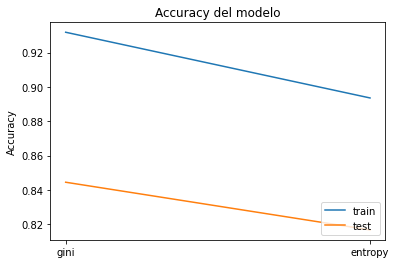

In [6]:
values = ['gini', 'entropy']

test({
  "criterion": values,
  "max_depth": [None],
  "min_samples_split": [2],
  "min_samples_leaf": [1],
  "max_leaf_nodes": [None]
})

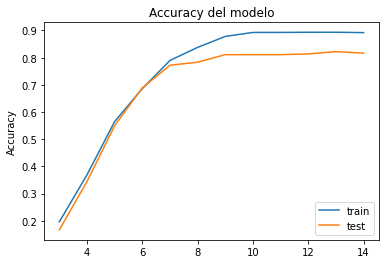

In [7]:
values = range(3, 15)

test({
  "criterion": ['entropy'],
  "max_depth": values,
  "min_samples_split": [2],
  "min_samples_leaf": [1],
  "max_leaf_nodes": [None]
})

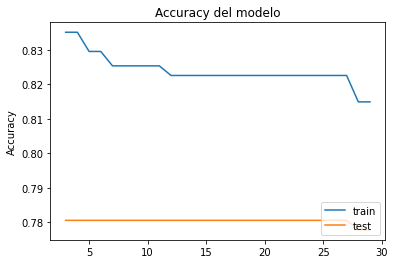

In [8]:
values = range(3, 30)

test({
  "criterion": ['entropy'],
  "max_depth": [8],
  "min_samples_split": values,
  "min_samples_leaf": [1],
  "max_leaf_nodes": [None]
})

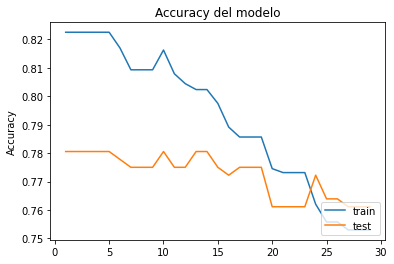

In [9]:
values = range(1, 30)

test({
  "criterion": ['entropy'],
  "max_depth": [8],
  "min_samples_split": [15],
  "min_samples_leaf": values,
  "max_leaf_nodes": [None]
})

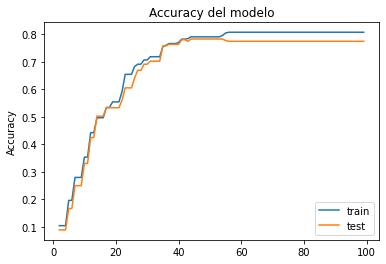

In [10]:
values = range(2, 100)

test({
  "criterion": ['entropy'],
  "max_depth": [8],
  "min_samples_split": [15],
  "min_samples_leaf": [11],
  "max_leaf_nodes": values
})

In [14]:
tree_model = DecisionTreeClassifier(criterion = 'entropy',
                                    splitter = "best",
                                    max_depth = 8,
                                    min_samples_leaf = 15,
                                    min_samples_split = 11,
                                    max_leaf_nodes = 60)

# Utilizamos el conjunto de datos de entrenamiento

tree_model.fit(data_train, target_train)


# Podo el árbol
pruned_tree_model = prune(tree_model, 2)

print(accuracy_score(target_train, pruned_tree_model.predict(data_train)))
print(accuracy_score(target_test, pruned_tree_model.predict(data_test)))

0.7974947807933194
0.775
